# Validation Set Creation for VAD/ Noise Reduction Experiments

- this notebook creates validation set for experimenting the effect of VAD/Noise reduction for forced alignments.

## Selection Process
- Randomly select sentence audio segments from `CHILDES/Gleason` dataset.
- Pick 5 children segment & 5 adult segment from each convo. Since there are 22 (`Father` category), 1 (`Mother` category) 13 (`Dinner` category) convos, there will be 360 (36x5x2) convos. 
- We call 180 child segments as `child_valid`, and 180 adult segments as `adult_valid`. Although we are focusing on child word detection, I am curious to see the performance on the adult dataset as well for future purpose.

## Model Comparison

1. VAD(sensitivity 2)
2. VAD(sensitivity 3)
3. VAD(sensitivity 2) + RNNoise
4. VAD(sensitivity 3) + RNNoise

## Evaluation Metric

The accuracy of forced alginment on each sample will be evaluated by humans. To make annotation easier, I will use these approximated score metric.

- 2: Good (All alignments match)
- 1: Acceptable (more than 2/3 of the alignments are correct)
- 0: Bad (otherwise)
- .: Data is Wrong

if the annotation is a single word, check if the silence/noise is removed appropriately and the segment of that word is inside.


In [1]:
import os
import random

import IPython.display as ipd

In [2]:
random.seed(17)

In [3]:
base_path = "scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/%s"
categories = ["Dinner", "Father", "Mother"]

In [4]:
valid_path = []
for cat in categories:
    for d in os.listdir(base_path % cat):
        path = (base_path + "/%s/") % (cat, d)
        # check if the path has the folder 'sentences_audio'
        if os.path.isdir(path + "sentences_audio"):
            valid_path.append(path)
len(valid_path), valid_path[0]

(36,
 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/')

In [5]:
from utils import load_transcription_file

def select_candidates(_texts, n=5):
    child = list(filter(lambda x: x[1] == "CHI", _texts))
    adult = list(filter(lambda x: x[1] != "CHI", _texts))

    print("Out of %s child's sentences, randomly selecting %s." 
          % (len(child), n))
    print("Out of %s adult's sentences, randomly selecting %s." 
      % (len(adult), n))
    return sample_text(child, n), sample_text(adult, n)

def sample_text(_texts, n):
    samples = []
    while len(samples) < n:
        s = random.choice(_texts)
        if len(s[2]) > 0 and s[2] != "aa":
            samples.append(s)
    return samples

def find_file_path(path, _id):
    files = os.listdir(path + "sentences_audio")
    for i, f in enumerate(files):
        if f.endswith(".mp4"):
            if int(f.split("_")[1]) == _id:
                return path + "sentences_audio/" + files[i]
    return None

In [600]:
child_samples = []
adult_samples = []
for path in valid_path:
    texts = load_transcription_file(path)
    _child_samples, _adult_samples = select_candidates(texts)
    for _id, _, s in _child_samples:
        f = find_file_path(path, _id)
        child_samples.append((f, s))
    for _id, _, s in _adult_samples:
        f = find_file_path(path, _id)
        adult_samples.append((f, s))
len(child_samples), len(adult_samples)


Loading scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentence_text.txt
Out of 134 child's sentences, randomly selecting 5.
Out of 256 adult's sentences, randomly selecting 5.

Loading scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/martin/sentence_text.txt
Out of 370 child's sentences, randomly selecting 5.
Out of 824 adult's sentences, randomly selecting 5.

Loading scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/sentence_text.txt
Out of 143 child's sentences, randomly selecting 5.
Out of 396 adult's sentences, randomly selecting 5.

Loading scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/laurel/sentence_text.txt
Out of 226 child's sentences, randomly selecting 5.
Out of 383 adult's sentences, randomly selecting 5.

Loading scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentence_text.txt
Out of 209 child's sentences, randomly selecting 5.
Out of 232 adult's sentences, r

(180, 180)

In [7]:
child_samples[:4]

[('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_387_789847_to_791542.mp4',
  'good shot'),
 ('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_323_680429_to_684469.mp4',
  'i do aa'),
 ('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_255_563004_to_564482.mp4',
  'ill choose'),
 ('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_297_629275_to_633095.mp4',
  'i want')]

In [18]:
f, s = random.choice(child_samples)
print(s)
ipd.Audio(f)

what


In [29]:
f, s = random.choice(adult_samples)
print(s)
ipd.Audio(filename=f)

thats very tricky and dangerous


In [22]:
with open("validation/child_valid.tsv", "w") as f1:
    f1.write("%s\t%s\n" % ("file_path", "annotation"))
    for f, s in child_samples:
        f1.write("%s\t%s\n" % (f, s))

with open("validation/adult_valid.tsv", "w") as f2:
    f2.write("%s\t%s\n" % ("file_path", "annotation"))
    for f, s in adult_samples:
        f2.write("%s\t%s\n" % (f, s))

## analysis of the valid set

In [30]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [31]:
_, child_s = zip(*child_samples)
_, adult_s = zip(*adult_samples)

### Lengths

In [32]:
child_lengths = [len(s.split()) for s in child_s]
adult_lengths = [len(s.split()) for s in adult_s]

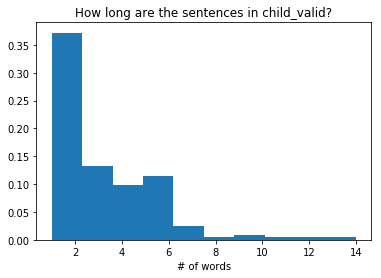

In [33]:
plt.title("How long are the sentences in child_valid?")
plt.hist(child_lengths, density=True)
plt.xlabel('# of words');

35% are single words!

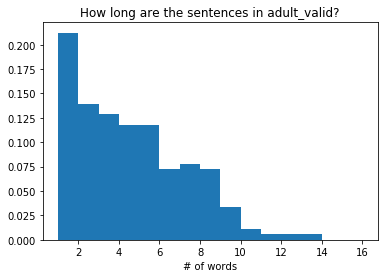

In [34]:
plt.title("How long are the sentences in adult_valid?")
plt.hist(adult_lengths, density=True, bins=range(min(adult_lengths), max(adult_lengths)))
plt.xlabel('# of words');

20+% are single words for adults, but tend to have longer sentences

### What is the most common words

#### Child
Most common words

In [35]:
words = []
for s in child_s:
    words += s.split()
Counter(words).most_common(10)

[('i', 31),
 ('yeah', 23),
 ('the', 16),
 ('and', 15),
 ('aa', 14),
 ('it', 12),
 ('is', 11),
 ('want', 10),
 ('down', 9),
 ('this', 9)]

Most common single words

In [36]:
single_words = filter(lambda x: len(x) == 1, [s.split() for s in child_s])
single_words = [s[0] for s in single_words]
Counter(single_words).most_common(5)

[('yeah', 16), ('no', 7), ('what', 6), ('okay', 3), ('oh', 2)]

#### Adults

In [37]:
words = []
for s in adult_s:
    words += s.split()
Counter(words).most_common(10)

[('you', 32),
 ('the', 27),
 ('it', 20),
 ('and', 18),
 ('that', 15),
 ('this', 13),
 ('okay', 12),
 ('to', 12),
 ('here', 11),
 ('on', 11)]

In [38]:
single_words = filter(lambda x: len(x) == 1, [s.split() for s in adult_s])
single_words = [s[0] for s in single_words]
Counter(single_words).most_common(5)

[('okay', 5), ('yeah', 4), ('right', 3), ('no', 3), ('oh', 2)]

## preprocess outputs

In [554]:
child_files, child_sentences = zip(*child_samples)
child_files[:3]

('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_387_789847_to_791542.mp4',
 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_323_680429_to_684469.mp4',
 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_255_563004_to_564482.mp4')

### resample original samples and rename (child)

In [93]:
for i, f in enumerate(child_files):
    output_file = "./validation/wav/child_%s.wav" % i
    !ffmpeg -i $f -ar 16000 -ac 1 $output_file

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_387_789847_to_791542.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/martin/sentences_audio/id_710_1534912_to_1539812.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/sentences_audio/id_533_1136377_to_1137971.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/laurel/sentences_audio/id_222_557913_to_558505.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_248_633872_to_635563.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/olivia/sentences_audio/id_214_495471_to_497781.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/eddie/sentences_audio/id_332_588101_to_588306.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/charlie/sentences_audio/id_47_102428_to_104031.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/david/sentences_audio/id_184_515274_to_516064.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/bobby/sentences_audio/id_496_1307701_to_1308642.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/john/sentences_audio/id_18_491336_to_495322.mp4':
  Metadata:
    major_brand     

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/helen/sentences_audio/id_730_1503671_to_1505111.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/katie/sentences_audio/id_292_548468_to_551198.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/victor/sentences_audio/id_565_1312848_to_1313126.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/william/sentences_audio/id_437_1013646_to_1014379.mp4':
  Metadata:
    major_bran

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/isadora/sentences_audio/id_697_963632_to_964433.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/martin/sentences_audio/id_435_1576927_to_1582563.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/guy/sentences_audio/id_51_367385_to_369068.mp4':
  Metadata:
    major_brand     :

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/ursula/sentences_audio/id_626_1168182_to_1169401.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/theresa/sentences_audio/id_668_1412581_to_1414578.mp4':
  Metadata:
    major_bran

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/laurel/sentences_audio/id_238_315296_to_315981.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/frank/sentences_audio/id_564_1656550_to_1661833.mp4':
  Metadata:
    major_brand 

size=     480kB time=00:00:15.37 bitrate= 256.0kbits/s speed= 848x    
video:0kB audio:480kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.015857%
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/olivia/sentences_audio/id_33_144294_to_144861.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/nanette/sentences_audio/id_61_306872_to_315705.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/eddie/sentences_audio/id_10_11622_to_13026.mp4':
  Metadata:
    major_brand     :

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/charlie/sentences_audio/id_517_892252_to_892912.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/david/sentences_audio/id_10_95528_to_100025.mp4':
  Metadata:
    major_brand     

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/patricia/sentences_audio/id_191_425397_to_430032.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/susan/sentences_audio/id_464_1183050_to_1183770.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/bobby/sentences_audio/id_220_411533_to_413269.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/john/sentences_audio/id_245_686402_to_687279.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/helen/sentences_audio/id_88_290800_to_296042.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/richard/sentences_audio/id_678_1108312_to_1111679.mp4':
  Metadata:
    major_bran

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/katie/sentences_audio/id_469_1256480_to_1262053.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Mother/andy/sentences_audio/id_108_450352_to_451650.mp4':
  Metadata:
    major_brand    

### apply denoising (child)

In [52]:
for i, f in enumerate(child_files):
    output_file = "validation/denoised/child_%s" % i
    !sh ~/Documents/rnnoise/denoise_mp4_wav.sh $f $output_file

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_323_680429_to_684469_rn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fbc7f001200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/martin

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ff9a9802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/sentences_audio/id_191_490321_to_492144_rnn.pcm':
  Duration: 00:00:01.84, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/sentences_audio/id_191_490321_to_492144_rnn.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     173kB time=00:00:01.84 bitrate= 768.3kbits/s speed= 591x    
video:0kB audio:172kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.044158%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyrigh

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/laurel/sentences_audio/id_337_802771_to_804222_rnn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ff784807400] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fbc96002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_73_163460_to_166516_rnn.pcm':
  Duration: 00:00:03.05, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_73_163460_to_166516_r

size=      30kB time=00:00:00.96 bitrate= 256.6kbits/s speed= 296x    
video:0kB audio:30kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.253906%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libs

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb027802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/olivia/sentences_audio/id_19_56610_to_57562_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.96, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_27.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      30kB time=00:00:00.96 bitrate= 256.6kbits/s speed= 378x    
video:0kB audio:30kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.253906%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#####

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe34d001200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/eddie/sentences_audio/id_71_118414_to_120010_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.61, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_32.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      50kB time=00:00:01.61 bitrate= 256.4kbits/s speed= 592x    
video:0kB audio:50kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.151398%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
####

size=     435kB time=00:00:04.64 bitrate= 768.0kbits/s speed= 239x    
video:0kB audio:435kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/charlie/sentences_audio/id_47_102428_to_104031_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.61, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_35.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      50kB time=00:00:01.61 bitrate= 256.4kbits/s speed= 670x    
video:0kB audio:50kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.151398%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f81b2002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe072000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_D

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/david/sentences_audio/id_89_314236_to_315571_rnn.w

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f86fb801200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Output #0, wav, to 'validation/denoised/child_46.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     111kB time=00:00:03.56 bitrate= 256.2kbits/s speed= 798x    
video:0kB audio:111kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.068469%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lz

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa779801200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/john/sentences_audio/id_540_1426996_to_1428700_rnn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8367800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/helen/sentences_audio/id_814_1691030_to_1693696_rn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fd8c2802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/helen/sentences_audio/id_365_767346_to_768797_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.47, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_59.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      46kB time=00:00:01.47 bitrate= 256.4kbits/s speed= 629x    
video:0kB audio:46kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.165816%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
###

size=     157kB time=00:00:01.67 bitrate= 768.0kbits/s speed= 365x    
video:0kB audio:157kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/katie/sentences_audio/id_811_1401301_to_1402383_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.10, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_62.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      34kB time=00:00:01.10 bitrate= 256.6kbits/s speed= 518x    
video:0kB audio:34kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.221591%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8015800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Output #0, wav, to 'validation/denoised/child_67.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      32kB time=00:00:01.01 bitrate= 256.6kbits/s speed= 461x    
video:0kB audio:32kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.241337%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzm

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb91c001200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/william/sentences_audio/id_482_1077034_to_1080461_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:03.42, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_72.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     107kB time=00:00:03.42 bitrate= 256.2kbits/s speed= 807x    
video:0kB audio:107kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.071272%
############# Remove intermediate files ##############
/Users/user/Documents/rnnois

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f970b800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/isadora/sentences_audio/id_697_963632_to_964433_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.82, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_75.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      26kB time=00:00:00.82 bitrate= 256.8kbits/s speed=25.4x    
video:0kB audio:26kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.297256%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa112800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/isadora/sentences_audio/id_770_1077981_to_1079055_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.10, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_78.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      34kB time=00:00:01.10 bitrate= 256.6kbits/s speed= 463x    
video:0kB audio:34kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.221591%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise

size=     532kB time=00:00:05.67 bitrate= 768.0kbits/s speed= 440x    
video:0kB audio:532kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/martin/sentences_audio/id_311_1163334_to_1171136_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:07.79, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_83.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     244kB time=00:00:07.79 bitrate= 256.1kbits/s speed= 980x    
video:0kB audio:243kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.031290%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc723802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/guy/sentences_audio/id_750_2229589_to_2230620_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.05, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_86.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      33kB time=00:00:01.05 bitrate= 256.6kbits/s speed= 368x    
video:0kB audio:33kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.232143%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
###

############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe9ad802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel L

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/guy/sentences_audio/id_186_705450_to_707226_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.78, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_89.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      56kB time=00:00:01.78 bitrate= 256.4kbits/s speed= 672x    
video:0kB audio:56kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.136938%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#####

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe7ab000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8a4f000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_D

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_99.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      42kB time=00:00:01.33 bitrate= 256.5kbits/s speed= 600x    
video:0kB audio:42kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.183271%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --ena

size=     313kB time=00:00:03.34 bitrate= 768.0kbits/s speed= 608x    
video:0kB audio:313kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/laurel/sentences_audio/id_28_57087_to_58380_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.29, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_104.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      40kB time=00:00:01.29 bitrate= 256.5kbits/s speed= 581x    
video:0kB audio:40kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.188953%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
####

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ffdc6802200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/frank/sentences_audio/id_60_157331_to_172691_rnn.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=    1440kB time=00:00:15.36 bitrate= 768.0kbits/s speed=1.3e+03x    
video:0kB audio:1440kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.005290%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enabl

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

size=     978kB time=00:00:10.43 bitrate= 768.1kbits/s speed=1.26e+03x    
video:0kB audio:978kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.007790%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fab06800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/olivia/sentences_audio/id_589_1265815_to_1297649_r

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb634802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

size=     277kB time=00:00:08.86 bitrate= 256.1kbits/s speed= 974x    
video:0kB audio:277kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.027511%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  lib

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f93d1002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/eddie/sentences_audio/id_10_11622_to_13026_rnn.wav

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f9ab4807400] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/eddie/sentences_audio/id_116_215417_to_217077_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.66, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_128.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      52kB time=00:00:01.66 bitrate= 256.4kbits/s speed= 541x    
video:0kB audio:52kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.146837%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f818c802a00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/charlie/sentences_audio/id_201_363933_to_365700_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.80, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_131.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      56kB time=00:00:01.80 bitrate= 256.3kbits/s speed= 639x    
video:0kB audio:56kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.135417%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise


############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f7f78800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Output #0, wav, to 'validation/denoised/child_134.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      27kB time=00:00:00.87 bitrate= 256.7kbits/s speed= 299x    
video:0kB audio:27kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.280172%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lz

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f94f8801c00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/david/sentences_audio/id_39_171029_to_174306_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:03.27, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_137.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     102kB time=00:00:03.27 bitrate= 256.2kbits/s speed= 725x    
video:0kB audio:102kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.074541%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc26a000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc5b5002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/patricia/sentences_audio/id_106_234727_to_236999_rnn.pcm':
  Duration: 00:00:02.29, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/patricia/sentences_audio/id_106_234727_to_236999_rnn.wav':
  Metadata:
    ISFT  

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/susan/sentences_audio/id_869_1915971_to_1917887_rn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc7ca800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/bobby/sentences_audio/id_220_411533_to_413269_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.75, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_150.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1]

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fac82802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

size=     338kB time=00:00:10.81 bitrate= 256.1kbits/s speed=1.07e+03x    
video:0kB audio:338kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.022549%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
 

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fbfc6807000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/john/sentences_audio/id_251_699929_to_703331_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:03.40, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/child_156.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     106kB time=00:00:03.40 bitrate= 256.2kbits/s speed= 863x    
video:0kB audio:106kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.071691%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8123000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/helen/sentences_audio/id_574_1284153_to_1286661_rnn.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     234kB time=00:00:02.50 bitrate= 768.2kbits/s speed= 756x    
video:0kB audio:234kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.032500%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
 

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/helen/sentences_audio/id_189_471602_to_480518_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fd2c3802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/katie/sentences_audio/id_114_545469_to_547930_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe8d3002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Mother

size=     482kB time=00:00:05.14 bitrate= 768.1kbits/s speed= 870x    
video:0kB audio:482kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.015807%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa12f800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

### resample original samples and rename (adult)

In [553]:
adult_files, adult_sentences = zip(*adult_samples)
files[:3]

('scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_135_338957_to_340884.mp4',
 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_207_480178_to_481908.mp4',
 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_88_233168_to_235432.mp4')

In [95]:
for i, f in enumerate(adult_files):
    output_file = "./validation/wav/adult_%s.wav" % i
    !ffmpeg -i $f -ar 16000 -ac 1 $output_file

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_135_338957_to_340884.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/martin/sentences_audio/id_984_2258552_to_2260630.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/sentences_audio/id_479_1040841_to_1041515.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/laurel/sentences_audio/id_510_1190252_to_1191938.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_391_1097867_to_1108270.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/olivia/sentences_audio/id_241_558100_to_558323.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/eddie/sentences_audio/id_195_356686_to_358091.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/charlie/sentences_audio/id_819_1526516_to_1527431.mp4':
  Metadata:
    major_bran

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/david/sentences_audio/id_96_321039_to_323419.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/bobby/sentences_audio/id_38_172221_to_173805.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/john/sentences_audio/id_100_628262_to_629658.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/helen/sentences_audio/id_353_756975_to_757729.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/katie/sentences_audio/id_454_820345_to_820763.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/victor/sentences_audio/id_607_1386808_to_1390233.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/william/sentences_audio/id_76_136500_to_138949.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/isadora/sentences_audio/id_131_217185_to_217731.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/martin/sentences_audio/id_523_1913391_to_1914743.mp4':
  Metadata:
    major_brand

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/guy/sentences_audio/id_312_1024449_to_1026231.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/ursula/sentences_audio/id_1065_1846937_to_1848353.mp4':
  Metadata:
    major_bran

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/theresa/sentences_audio/id_412_928261_to_929689.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/laurel/sentences_audio/id_430_581960_to_584399.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/frank/sentences_audio/id_252_819483_to_821363.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/andy/sentences_audio/id_461_1775719_to_1776833.mp4':
  Metadata:
    major_brand  

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/olivia/sentences_audio/id_48_166927_to_168844.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/nanette/sentences_audio/id_250_928871_to_929626.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/eddie/sentences_audio/id_953_1741230_to_1741984.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/charlie/sentences_audio/id_434_721181_to_722296.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/david/sentences_audio/id_45_178199_to_178589.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/patricia/sentences_audio/id_779_1430344_to_1431845.mp4':
  Metadata:
    major_bra

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/susan/sentences_audio/id_658_1559486_to_1563921.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/bobby/sentences_audio/id_829_1437031_to_1438534.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/john/sentences_audio/id_173_525450_to_526527.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/helen/sentences_audio/id_72_256477_to_258108.mp4':
  Metadata:
    major_brand    

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/richard/sentences_audio/id_402_679061_to_682266.mp4':
  Metadata:
    major_brand 

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/katie/sentences_audio/id_203_730252_to_731576.mp4':
  Metadata:
    major_brand   

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Mother/andy/sentences_audio/id_356_1248502_to_1250681.mp4':
  Metadata:
    major_brand  

### apply denoising (adult)

In [60]:
for i, f in enumerate(files):
    output_file = "validation/denoised/adult_%s" % i
    !sh ~/Documents/rnnoise/denoise_mp4_wav.sh $f $output_file

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/isadora/sentences_audio/id_207_480178_to_481908_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.75, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_1.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1]

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fef58002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/guy/se

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fee9c000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/laurel/sentences_audio/id_510_1190252_to_1191938_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.70, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_15.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa153801200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb1e3802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_391_1097867_to_1108270_rnn.pcm':
  Duration: 00:00:10.43, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/andy/sentences_audio/id_391_1097867_to_110

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/olivia/sentences_audio/id_241_558100_to_558323_rnn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f83a0801200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/eddie/sentences_audio/id_195_356686_to_358091_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe50d000e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/charlie/sentences_audio/id_819_1526516_to_1527431_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.91, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_35.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le (

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f930b800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/charlie/sentences_audio/id_175_327023_to_328358_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.33, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_38.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      42kB time=00:00:01.33 bitrate= 256.5kbits/s speed= 623x    
video:0kB audio:42kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.183271%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb382002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/david/sentences_audio/id_687_1537523_to_1538930_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.42, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_41.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1

size=     139kB time=00:00:01.48 bitrate= 768.0kbits/s speed= 457x    
video:0kB audio:139kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/david/sentences_audio/id_609_1400631_to_1401780_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.15, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_44.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      36kB time=00:00:01.15 bitrate= 256.5kbits/s speed= 535x    
video:0kB audio:36kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.211957%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f853c802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

size=      32kB time=00:00:01.01 bitrate= 256.6kbits/s speed= 444x    
video:0kB audio:32kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.241337%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libs

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f9c57802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/john/sentences_audio/id_100_628262_to_629658_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.42, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_50.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      44kB time=00:00:01.42 bitrate= 256.4kbits/s speed= 596x    
video:0kB audio:44kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.171655%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
####

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe8b1800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/helen/sentences_audio/id_151_311980_to_320827_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:08.86, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_57.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ffa6a802200] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner

############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Dinner/katie/

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f886c002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

size=     107kB time=00:00:03.42 bitrate= 256.2kbits/s speed= 913x    
video:0kB audio:107kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.071272%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  lib

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc18c800400] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     230kB time=00:00:02.45 bitrate= 768.3kbits/s speed= 764x    
video:0kB audio:230kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.033163%
############# Downsample WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 / 

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe1a6800400] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/william/sentences_audio/id_769_1841920_to_1846804_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:04.91, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_73.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     154kB time=00:00:04.91 bitrate= 256.1kbits/s speed= 798x    
video:0kB audio:153kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.049644%
############# Remove intermediate files ##############
/Users/user/Documents/rnnois

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ffc67002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/isadora/sentences_audio/id_373_534651_to_535576_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.91, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_78.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      29kB time=00:00:00.91 bitrate= 256.7kbits/s speed= 392x    
video:0kB audio:28kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.267857%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
#

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc26b802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/martin/sentences_audio/id_411_1487802_to_1488742_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.97, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_81.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([

############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fbf52002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel L

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/guy/sentences_audio/id_447_1445900_to_1446976_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc23e802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/ursula/sentences_audio/id_173_394519_to_395367_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.87, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_91.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      27kB time=00:00:00.87 bitrate= 256.7kbits/s speed= 437x    
video:0kB audio:27kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.280172%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe880802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

[s16le @ 0x7fc89a800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/laurel/sentences_audio/id_430_581960_to_584399_rnn.pcm':
  Duration: 00:00:02.45, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/laurel/sentences_audio/id_430_581960_to_584399_rnn.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     230kB time=00:00:02.45 bitrate= 768.3kbits/s speed= 781x    
video:0kB audio:230kB subtitle:0kB other streams:0kB global headers:0kB muxing overh

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/frank/sentences_audio/id_252_819483_to_821363_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.89, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_105.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1]

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8cf1800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Output #0, wav, to 'validation/denoised/adult_110.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      34kB time=00:00:01.10 bitrate= 256.6kbits/s speed= 540x    
video:0kB audio:34kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.221591%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lz

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f9300800400] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/olivia/sentences_audio/id_48_166927_to_168844_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa1d3802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/nanette/sentences_audio/id_406_1395557_to_1397440_

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7ffe22002e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/eddie/sentences_audio/id_509_979466_to_979640_rnn.

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f84c1802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fd6b6002600] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_D

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/charlie/sentences_audio/id_387_653942_to_655549_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:01.61, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_133.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe087802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_138.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      25kB time=00:00:00.80 bitrate= 256.8kbits/s speed= 412x    
video:0kB audio:25kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.304688%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --e

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fb0e7802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

size=      50kB time=00:00:01.61 bitrate= 256.4kbits/s speed= 659x    
video:0kB audio:50kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.151398%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libs

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f93f5800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/susan/sentences_audio/id_92_451048_to_454647_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:03.61, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_146.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=     113kB time=00:00:03.61 bitrate= 256.2kbits/s speed= 896x    
video:0kB audio:113kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.067521%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
##

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fe3a8802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/bobby/sentences_audio/id_689_1176201_to_1177111_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:00.91, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_151.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      29kB time=00:00:00.91 bitrate= 256.7kbits/s speed= 374x    
video:0kB audio:28kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.267857%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise


############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f9f0f802e00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

[s16le @ 0x7ff274801c00] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/john/sentences_audio/id_479_1183388_to_1183800_rnn.pcm':
  Duration: 00:00:00.41, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le, 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/john/sentences_audio/id_479_1183388_to_1183800_rnn.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      39kB time=00:00:00.41 bitrate= 769.5kbits/s speed= 218x    
video:0kB audio:38kB subtitle:0kB other streams:0kB global headers:0kB muxing overhe

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_an

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fc3a4000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, s16le, from 'scraping_and_segmentation/Audio_D

  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/helen/sentences_audio/id_73_258108_to_260216_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:02.12, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_162.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][

size=     124kB time=00:00:01.32 bitrate= 768.0kbits/s speed= 279x    
video:0kB audio:124kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000000%
############# Denoising ##############
############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresa

size=     101kB time=00:00:03.24 bitrate= 256.2kbits/s speed= 766x    
video:0kB audio:101kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.075231%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  lib

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7faf48000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/richard/sentences_audio/id_489_816678_to_819209_rnn.wav':
  Metadata:
    encoder         : Lavf58.12.100
  Duration: 00:00:02.54, bitrate: 768 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, mono, s16, 768 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'validation/denoised/adult_168.wav':
  Metadata:
    ISFT            : Lavf58.12.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, mono, s16, 256 kb/s
    Metadata:
      encoder         : Lavc58.18.100 pcm_s16le
size=      79kB time=00:00:02.54 bitrate= 256.2kbits/s speed= 449x    
video:0kB audio:79kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.095965%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise


############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f8bfc800000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Guessed Channel Layout for Input Stream #0.0 : mono
Input #0, wav, from 'scraping_and_segmentation/Audio_Data/CHILDES/Eng-NA/Gleason/Father/katie/sentences_audio/id_430_1193222_to_1194499_rn

############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7fa05a000000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

size=    1210kB time=00:00:38.72 bitrate= 256.0kbits/s speed=1.05e+03x    
video:0kB audio:1210kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.006295%
############# Remove intermediate files ##############
/Users/user/Documents/rnnoise
############# Transforming mp4 to pcm ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0


############# Convert it back to WAV ##############
ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
[s16le @ 0x7f9359807000] Estimating duration from bitrate, this may be inaccurate
Guessed Channel Layout for Input Stream #0.0 : mono
Inpu

## first validate whether this samples are good
4 - backgroud noise
3 - voice overlap
2 - wrong segmentation
1 - inaudible audio
0 - no problem

In [544]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [616]:
def get_adult_wav(i):
    print(adult_sentences[i])
    return ipd.Audio("validation/wav/adult_%s.wav" % i)

def get_child_wav(i):
    print(child_sentences[i])
    return ipd.Audio("validation/wav/child_%s.wav" % i)

def get_denoised_adult_wav(i):
    print(adult_sentences[i])
    return ipd.Audio("validation/denoised/adult_%s.wav" % i)

def get_denoised_child_wav(i):
    print(child_sentences[i])
    return ipd.Audio("validation/denoised/child_%s.wav" % i)

In [579]:
df_adult = pd.read_csv("./validation/check_samples_adult.txt")
df_child = pd.read_csv("./validation/check_samples_child.txt")


/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


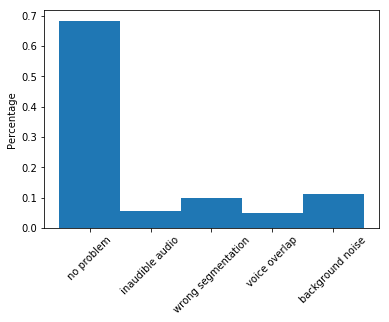

In [550]:
%matplotlib inline
plt.hist(df_adult["wav"], normed=True, bins=range(0,6))
plt.ylabel('Percentage');
x= np.arange(5)
plt.xticks(x+.5, ["no problem", 
                  "inaudible audio", 
                  "wrong segmentation",
                  "voice overlap",
                  "background noise"], rotation=45);



/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


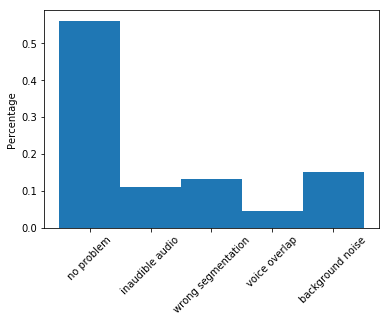

In [580]:
%matplotlib inline
plt.hist(df_child["wav"], normed=True, bins=range(0,6))
plt.ylabel('Percentage');
x= np.arange(5)
plt.xticks(x+.5, ["no problem", 
                  "inaudible audio", 
                  "wrong segmentation",
                  "voice overlap",
                  "background noise"], rotation=45);



In [593]:
df_adult["interview"] = [f.split("/")[-4] + "_" + f.split("/")[-3] for f in adult_files]
df_adult.describe(include="all")

,wav,interview
count,180.000000,180
unique,NaN,36
top,NaN,Father_guy
freq,NaN,5
mean,0.850000,NaN
std,1.404204,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,2.000000,NaN


In [581]:
df_child["interview"] = [f.split("/")[-4] + "_" + f.split("/")[-3] for f in child_files]
df_child.describe(include="all")

,wav,interview
count,180.000000,180
unique,NaN,36
top,NaN,Father_guy
freq,NaN,5
mean,1.111111,NaN
std,1.490712,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,2.000000,NaN


### samples from these interviews are not great.

In [673]:
child_counts = df_child[df_child["wav"] == 0].groupby(["interview"]).count()
child_counts[child_counts["wav"] < 3]

,wav
interview,
Dinner_charlie,1
Dinner_david,1
Dinner_helen,2
Dinner_isadora,2
Dinner_john,2
Dinner_katie,2
Dinner_laurel,2
Dinner_olivia,2
Father_david,1


In [683]:
df_child[df_child["interview"] == "Father_ursula"]

,wav,interview
90,4,Father_ursula
91,0,Father_ursula
92,1,Father_ursula
93,0,Father_ursula
94,1,Father_ursula


- dinner_charlie: the baby is too far away from the microphone (O)
- dinner_david: everyone is too far away from the microphone (O)
- father_david: too much noise from toy overlapping (O)
- father_helen: too much noise (X)
- father_martin: the baby pronunciation is not correct. (X)
- father_nanette: the baby pronunciation is not correct (X)

O,X from blind test

In [672]:
adult_counts = df_adult[df_adult["wav"] == 0].groupby(["interview"]).count()
adult_counts[adult_counts["wav"] < 3]

,wav
interview,
Dinner_andy,1
Dinner_isadora,1
Dinner_john,2
Dinner_martin,2
Father_david,2
Father_richard,2
Father_william,1
Mother_andy,1


In [652]:
i = -1

In [671]:
i += 1
print(i+2)
get_denoised_child_wav(i)

20
alright
